# Бустинги

## Фактура задания

Вручную запрограммируем один из самых мощных алгоритмов машинного обучения — бустинг. Однако с большой силой приходит и большая ответственность...

In [1]:
from warnings import filterwarnings

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set(style='darkgrid')
filterwarnings('ignore')

Я буду работать с датасетом по предсказанию гендера. Никакие фичи придумывать не будем. В датасете имеется:

- region — регион, в котором проводили опрос
- age — возраст опрошенного
- year — год опроса
- race — этническая принадлежность
- sch — количество классов образования
- empstat — статус трудоустройства
- occ — код профессии
- ind — код индустрии, в которой человек работает
- annhrs — число часов работы в год
- hrwage — почасовая оплата
- icwage — суммарная оплата в год
- occupation — должность

Целевая метрика ROC-AUC, потому что мы непритязательны и это не фокус работы

In [4]:
df = pd.read_parquet("boosting_dataset.pq")

X = df.drop("sex", axis=1)
y = df["sex"]

Пока что мы временно выкинем колонку с должностью, но мы к ней обязательно вернемся

Разделим на обучающую, валидационную и тестовую выборки (оставьте `random_state=1337` для воспроизводимости).

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X.drop("occupation", axis=1).values, y.values, test_size=0.2, random_state=1337
)
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test, test_size=0.5, random_state=1337
)

X_train.shape, X_valid.shape, X_test.shape

((8000, 11), (1000, 11), (1000, 11))

---

## 1. Базовый градиентный бустинг 

Пропишем код в файлике `boosting.py`. 

### Особенности функций:

#### `__init__`

Существующие параметры:
- `base_model_class` — класс базовой модели нашего бустинга
- `base_model_params` — словарь с гиперпараметрами для базовой модели
- `n_estimators` — какое количество базовых моделей нужно обучить
- `learning_rate` — темп обучения, должен быть из полуинтервала $(0, 1]$
- `random_state`— в роли рандом стейта
- `verbose` — можно включить и увидеть, сколько еще ждать конца обучения

#### `fit`

В `fit` приходит выборка, на которой мы обучаем новые базовые модели

1. Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`).
2. После этого нужно обучить `n_estimators` базовых моделей.
3. После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на выборке (использую `loss_fn` для этого) и найти новую оптимальную гамму

#### `partial_fit`

В `partial_fit` передаются данные `X: np.ndarray, y: np.ndarray` для одного шага бустинга: обучаем следующую базовую модель на антиградиенте и обновляем ансамбль.

#### `predict_proba`

В `predict_proba` приходит любая выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду

In [10]:
%load_ext autoreload

In [12]:
%autoreload 2

from boosting import Boosting

### Проверка кода

In [15]:
boosting = Boosting(
    verbose=True,
    random_state=69, 
)

boosting.fit(X_train, y_train)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2), "prediction shapes are incorrect"
assert np.array_equal(boosting.history["train_loss"], np.sort(boosting.history["train_loss"])[::-1]), "train loss is not decreasing"

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

# здесь и далее работаем с метрикой ROC-AUC
print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

Train ROC-AUC 1.0000
Valid ROC-AUC 0.7028
Test ROC-AUC 0.7211


---

## 2. Имплементация гиперпараметров 

Бустинг, как метод агрегации, предлагает несколько вариантов регуляризации.

Я буду делать кучу самых разных гиперпараметров, каждый из них прекрасен по-своему, но полноценно их эффект получится ощутить лишь на этапе их перебора (кроме, пожалуй, `rsm`).

### 2.1. Борьба с переобучением 

Как известно, бустинги бывают склонны к переобучению. Чтобы этого не допустить, можно контролировать процесс обучения и проверять критерий останова на валидации прямо во время обучения. Реализуем такую процедуру. Также нельзя забывать, что всю предобработку для трейна, нужно будет повторить на валидации.

Добавим в модель:
- `early_stopping_rounds: int | None = 0` — число раундов для критерия останова. Если качество ухудшается на протяжении всех раундов подряд, останавливаем обучение
- `eval_metric: str | None = None` — метрика, на которую смотрим, чтобы остановить обучение, может быть ключом из `model.history`
- `plot_history(self, keys: str | Iterable[str])` — метод, который строит график изменения метрики по ключам из `model.history`

И конкретно в метод `model.fit`:
- `eval_set: Tuple[np.ndarray] | None = None` — валидационная выборка `X_valid: np.ndarray, y_valid: np.ndarray`, на которой будем проверять переобучение
- `use_best_model: bool = False` — использовать лучшую модель, или нет. Если да, то отрезаем гаммы и модели вплоть до той, на которой остановились, минус `early_stopping_rounds`, т.е самой лучшей, после которой качество только падает

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td colspan="3" align="center"><code>early_stopping_rounds</code>, <code>eval_set</code></td>
</tr>
</table>

</div>

All basic assertions passed!
Train ROC-AUC 1.0000
Valid ROC-AUC 0.7033
Test ROC-AUC 0.7263


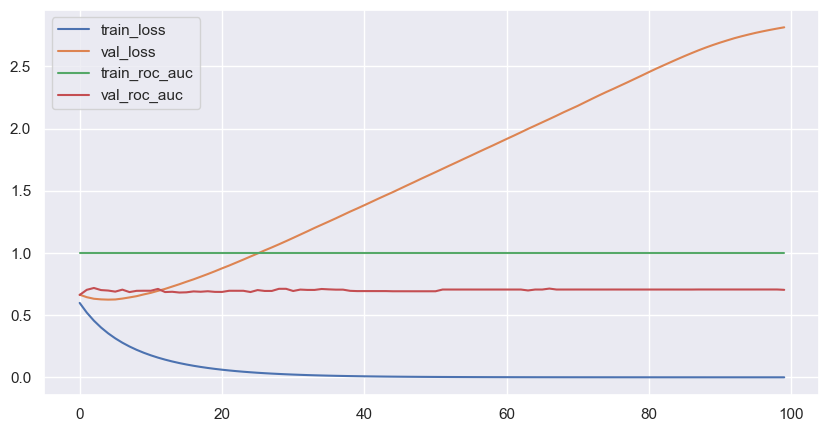


Testing Early Stopping
Stopped at iteration: 3
Final Valid ROC-AUC (Best Model): 0.7290


In [28]:
boosting = Boosting(
    n_estimators=100,
    learning_rate=0.1,
    early_stopping_rounds=None, # Для теста monotonic loss лучше пока выключить ES или поставить большим
    verbose=True,
    random_state=69 
)


boosting.fit(X_train, y_train, eval_set=(X_valid, y_valid))

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2), "prediction shapes are incorrect"

train_losses = boosting.history["train_loss"]
assert np.all(np.diff(train_losses) <= 1e-9), "train loss is not decreasing monotonically"

print("All basic assertions passed!")


print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

boosting.plot_history(["train_loss", "val_loss", "train_roc_auc", "val_roc_auc"])

print("\nTesting Early Stopping")
boosting_es = Boosting(
    n_estimators=500, 
    learning_rate=0.1,
    early_stopping_rounds=10, 
    eval_metric='val_roc_auc', 
    random_state=66
)
boosting_es.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

print(f"Stopped at iteration: {len(boosting_es.models)}")
print(f"Final Valid ROC-AUC (Best Model): {boosting_es.score(X_valid, y_valid):.4f}")

### Бустинг линейных моделей 

<font color='#b962c4'> Размышления: Возможно, ансамблирование линейных моделей помогло бы увеличить качество, но набиолее полезно это в ситуациях отличных от рассматриваемых, например, для bag-of-words в текстах, ведь там ансамблирование поможет снизить разреженность.</font>

Обучим бустинг, где в качестве базовой модели будет линейная регрессия. Сохраним историю функции потерь и зафиксируем время обучения. Возьму уже готовый из <font color='#2f82d4'>**XGBoost**</font> и достану оттуда историю обучения.

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center"><code>XGBClassifier(booster="gblinear")</code></td>
<td align="center">-</td>
<td align="center">-</td>
</tr>
</table>

</div>

XGBoost (gblinear) Training time: 0.1611 seconds
XGBoost Test ROC-AUC: 0.7384


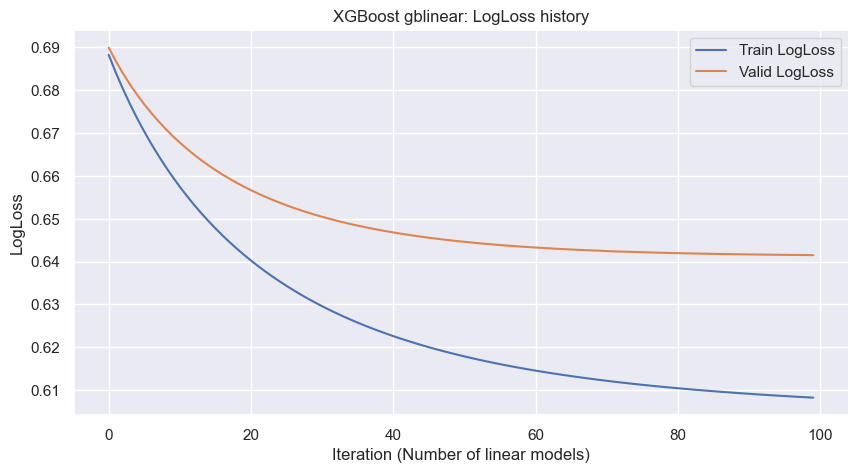

[0.6416860533139261,
 0.6416638913477218,
 0.6416428297364036,
 0.6416228125004564,
 0.6416037856073599,
 0.6415857050600243,
 0.6415685313787545,
 0.6415521989015833,
 0.641536688582033,
 0.641522421365793]

In [32]:
import time
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

y_train_mapped = np.where(y_train == -1, 0, y_train)
y_valid_mapped = np.where(y_valid == -1, 0, y_valid)
y_test_mapped = np.where(y_test == -1, 0, y_test)

xgb_linear = xgb.XGBClassifier(
    booster='gblinear',
    n_estimators=100,
    learning_rate=0.1,
    random_state=888,
    n_jobs=-1,
    eval_metric='logloss',
    objective='binary:logistic'
)

start_time = time.time()

xgb_linear.fit(
    X_train, y_train_mapped,
    eval_set=[(X_train, y_train_mapped), (X_valid, y_valid_mapped)],
    verbose=False
)

end_time = time.time()
xgb_training_time = end_time - start_time

# Сохраняем историю 
results = xgb_linear.evals_result()
xgb_train_loss = results['validation_0']['logloss']
xgb_valid_loss = results['validation_1']['logloss']

print(f"XGBoost (gblinear) Training time: {xgb_training_time:.4f} seconds")
print(f"XGBoost Test ROC-AUC: {roc_auc_score(y_test_mapped, xgb_linear.predict_proba(X_test)[:, 1]):.4f}")

plt.figure(figsize=(10, 5))
plt.plot(xgb_train_loss, label='Train LogLoss')
plt.plot(xgb_valid_loss, label='Valid LogLoss')
plt.title('XGBoost gblinear: LogLoss history')
plt.xlabel('Iteration (Number of linear models)')
plt.ylabel('LogLoss')
plt.legend()
plt.grid(True)
plt.show()

xgb_valid_loss[-10:]

Теперь возьмем `sklearn.linear_model.SGDClassifier` и обучим на тех же данных. 

In [35]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

n_epochs = 100
sgd_model = SGDClassifier(
    loss='log_loss', 
    penalty='l2', 
    alpha=0.88, 
    learning_rate='optimal', 
    random_state=888, 
    n_jobs=-1
)

sgd_train_loss = []
sgd_valid_loss = []
classes = np.unique(y_train_mapped) 


start_time = time.time()

for epoch in range(n_epochs):
    sgd_model.partial_fit(X_train, y_train_mapped, classes=classes)
    
    y_train_pred_prob = sgd_model.predict_proba(X_train)
    y_valid_pred_prob = sgd_model.predict_proba(X_valid)
    
    sgd_train_loss.append(log_loss(y_train_mapped, y_train_pred_prob))
    sgd_valid_loss.append(log_loss(y_valid_mapped, y_valid_pred_prob))

end_time = time.time()
sgd_training_time = end_time - start_time

print(f"SGDClassifier Training time: {sgd_training_time:.4f} seconds")
print(f"SGD Test ROC-AUC: {roc_auc_score(y_test_mapped, sgd_model.predict_proba(X_test)[:, 1]):.4f}")

SGDClassifier Training time: 0.5543 seconds
SGD Test ROC-AUC: 0.7103


Отобразим на одном графике изменение функции потерь для бустинга и SGD классификатора. Сравним следующие детали у бустинга и линейной модели:

- время обучения
- сходимость (как быстро, как стабильно)
- графики функции потерь на трейне и на валидации

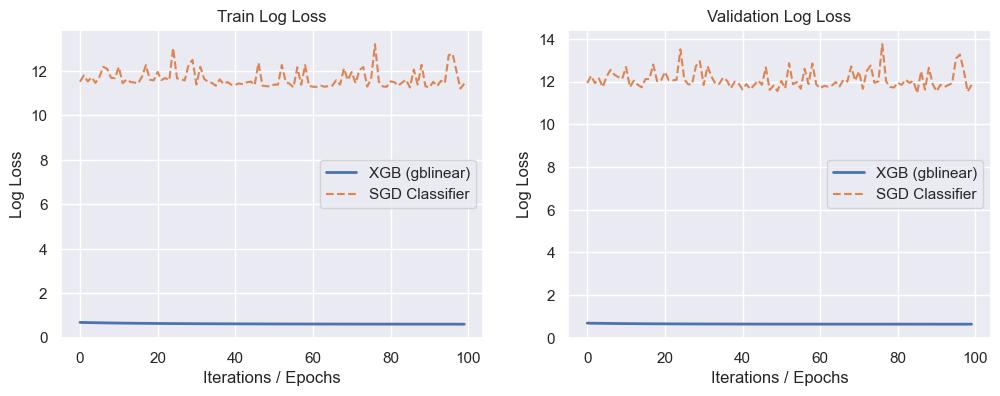

Время обучения XGBoost (gblinear): 0.16113 сек
Время обучения SGDClassifier:      0.55432 сек


In [40]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(xgb_train_loss, label='XGB (gblinear)', linewidth=2)
plt.plot(sgd_train_loss, label='SGD Classifier', linestyle='--')
plt.title('Train Log Loss')
plt.xlabel('Iterations / Epochs')
plt.ylabel('Log Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(xgb_valid_loss, label='XGB (gblinear)', linewidth=2)
plt.plot(sgd_valid_loss, label='SGD Classifier', linestyle='--')
plt.title('Validation Log Loss')
plt.xlabel('Iterations / Epochs')
plt.ylabel('Log Loss')
plt.legend()

plt.show()

print(f"Время обучения XGBoost (gblinear): {xgb_training_time:.5f} сек")
print(f"Время обучения SGDClassifier:      {sgd_training_time:.5f} сек")

<font color='#b962c4'>
Сходимость: XGBoost использует координатный спуск, что делает его график более гладким и монотонным. А SGD может больше шуметь и сходиться с высокой волатильностью.</font>

### 2.2. Категории 2.0 

Пока что мы игнорировали категориальные признаки. <font color='#c4bf0a'>CatBoost</font> в частности предлагает один из самых эффективных и быстрых вариантов кодировки категорий, который я повторю.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$


Можно просто добавить в модель вот это:
- `cat_features: Iterable | None` — категориальные признаки для кодирования
- `_cat_fit(self, X: np.array, y: np.ndarray)` — внутренний метод для построения счетчиков
- `_cat_transform(self, X: np.ndarray)` — внутренний метод для применения счетчиков

Но лучше сделать энкодер отдельным классом с аналогичными методами `fit` и `transform`. Его нужно прогнать всего раз для каждой из выборок

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center">-</td>
<td align="center">-</td>
<td align="center"><code>cat_features</code></td>
</tr>
</table>

</div>

Закодируем переменные с помощью счётчиков и покажем эффект. Стараемся, чтобы все было векторизовано.

In [44]:
# вернем occupation туда, где ему самое место, но это не единственная кат фича!

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=1337
)
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test, test_size=0.5, random_state=1337
)

X_train.shape, X_valid.shape, X_test.shape

((8000, 12), (1000, 12), (1000, 12))

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features: list[int], alpha: float = 10.0):
        self.cat_features = cat_features
        self.alpha = alpha
        self.mappings = {}
        self.global_mean = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        df = pd.DataFrame(X)
        self.global_mean = np.mean(y)

        for col_idx in self.cat_features:
            stats = pd.DataFrame({'y': y, 'group': df[col_idx]}).groupby('group')['y'].agg(['sum', 'count'])
            
            smoothed_mean = (stats['sum'] + self.alpha * self.global_mean) / (stats['count'] + self.alpha)
            
            self.mappings[col_idx] = smoothed_mean.to_dict()
            
        return self

    def transform(self, X: np.ndarray):
        X_transformed = X.copy()
        df = pd.DataFrame(X_transformed)

        for col_idx in self.cat_features:
            if col_idx in self.mappings:
                mapped_col = df[col_idx].map(self.mappings[col_idx]).fillna(self.global_mean)
                X_transformed[:, col_idx] = mapped_col.values
        
        return X_transformed.astype(float)

In [48]:
cat_cols_indices = [0, 3, 5, 6, 7, 11]

y_train_bin = np.where(y_train == -1, 0, y_train)
y_valid_bin = np.where(y_valid == -1, 0, y_valid)
y_test_bin = np.where(y_test == -1, 0, y_test)

encoder = TargetEncoder(cat_features=cat_cols_indices, alpha=10.0)

encoder.fit(X_train, y_train_bin)

X_train_enc = encoder.transform(X_train)
X_valid_enc = encoder.transform(X_valid)
X_test_enc = encoder.transform(X_test)

print("Размерность:", X_train_enc.shape)
print("Пример закодированного столбца Occupation:")
print(X_train_enc[:5, 11]) 


model_enc = Boosting(
    base_model_params={'max_depth': 3, 'min_samples_leaf': 10}, 
    n_estimators=50,
    learning_rate=0.1,
    random_state=888, 
    early_stopping_rounds=10,
    eval_metric='val_roc_auc',
    verbose=True
)

print("\nОбучение бустинга на закодированных данных")
model_enc.fit(
    X_train_enc, y_train_bin, 
    eval_set=(X_valid_enc, y_valid_bin),
    use_best_model=True
)

score = model_enc.score(X_test_enc, y_test_bin) 
print(f"\n ROC-AUC on Test with TE: {score:.4f}")

Размерность: (8000, 12)
Пример закодированного столбца Occupation:
[0.45628302 0.58119898 0.49065957 0.79695533 0.79695533]

Обучение бустинга на закодированных данных

 ROC-AUC on Test with TE: 0.8537


### Категории 3.0 

Поскольку закодированные признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем утечку целевой переменной в признаки, но с этим можно жить, в частности это одна из главных фишек <font color='#c4bf0a'>CatBoost</font>, была. См. [статью](https://arxiv.org/pdf/1706.09516), она интересная.

Реализуем подсчет счетчиков так, чтобы кодировка категории была только по объектам, расположенным выше в датасете (например, если у нас выборка отсортирована по времени).

Методы добавлять не обязательно, разве что очень хочется, предполагается, что это дефолтное поведение бустинга, на самом деле, если не нужен `OneHotEncoder `.

In [51]:
from typing import List, Optional

class OrderedTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features: List[int], alpha: float = 1.0, random_state: Optional[int] = None):
        self.cat_features = cat_features
        self.alpha = alpha  
        self.random_state = random_state
        self.mappings = {} 
        self.global_mean = 0.0

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.global_mean = np.mean(y)
        df = pd.DataFrame(X)
        
        for col_idx in self.cat_features:
            col_series = df[col_idx]
            stats = pd.DataFrame({'val': col_series, 'target': y}).groupby('val')['target'].agg(['sum', 'count'])
            
            smoothed_mean = (stats['sum'] + self.alpha * self.global_mean) / (stats['count'] + self.alpha)
            self.mappings[col_idx] = smoothed_mean.to_dict()
            
        return self

    def transform(self, X: np.ndarray, y: Optional[np.ndarray] = None, is_train: bool = False):
        X_transformed = X.copy()
        n_samples = X.shape[0]

        if is_train and y is not None:
            rng = np.random.default_rng(self.random_state)
            permutation = rng.permutation(n_samples)
            
            temp_df = pd.DataFrame({
                'idx': np.arange(n_samples),
                'y': y
            })
            
            for col_idx in self.cat_features:
                temp_df['feature'] = X[:, col_idx]
                shuffled = temp_df.iloc[permutation].copy()
                
                grouped = shuffled.groupby('feature')['y']
                cum_sum = grouped.cumsum().shift(1).fillna(0)
                cum_count = grouped.cumcount().shift(1).fillna(0)
                
                encoded = (cum_sum + self.global_mean) / (cum_count + 1)
                
                X_transformed[shuffled['idx'].values, col_idx] = encoded.values
        else:
            for col_idx in self.cat_features:
                mapping = self.mappings.get(col_idx, {})
                col_vals = X[:, col_idx]
                encoded_col = pd.Series(col_vals).map(mapping).fillna(self.global_mean).values
                X_transformed[:, col_idx] = encoded_col
        return X_transformed.astype(float)

In [53]:
cat_cols_indices = [0, 3, 5, 6, 7, 11]

y_train_bin = np.where(y_train == -1, 0, y_train)
y_valid_bin = np.where(y_valid == -1, 0, y_valid)
y_test_bin = np.where(y_test == -1, 0, y_test)

encoder = OrderedTargetEncoder(cat_features=cat_cols_indices, alpha=10.0, random_state=888)

encoder.fit(X_train, y_train_bin)

X_train_enc = encoder.transform(X_train, y=y_train_bin, is_train=True)
X_valid_enc = encoder.transform(X_valid)
X_test_enc = encoder.transform(X_test)

print("Размерность:", X_train_enc.shape)
print("Пример закодированного столбца:")
print(X_train_enc[:5, 11]) 


model_enc = Boosting(
    base_model_params={'max_depth': 3, 'min_samples_leaf': 10}, 
    n_estimators=50,
    learning_rate=0.1,
    random_state=888, 
    early_stopping_rounds=10,
    eval_metric='val_roc_auc',
    verbose=True
)

print("\nОбучение бустинга на закодированных данных")
model_enc.fit(
    X_train_enc, y_train_bin, 
    eval_set=(X_valid_enc, y_valid_bin),
    use_best_model=True
)


score = model_enc.score(X_test_enc, y_test_bin) 
print(f"\nROC-AUC on Test with TE: {score:.4f}")

Размерность: (8000, 12)
Пример закодированного столбца:
[0.10155691 0.03359262 0.77719967 0.79822215 0.8351267 ]

Обучение бустинга на закодированных данных

ROC-AUC on Test with TE: 0.7355


### 2.3. Бутстрап 
Как известно, при обучении базовых алгоритмов в беггинге, используется бутстрапированная выборка. Почему бы не попробовать сделать то же самое в бустинге?

> Идея - бустинги переобучаются, как черти. Бутстрап же может сделать процесс куда более робастным и быть одним из способов регуляризации, а заодно уменьшить время обучения, в случае бутстрапа Бернулли

Реализуем параметры:
- `subsample: float = 1.0` — доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей). Соответствует бутстрапу типа `Bernoulli`. Каждый объект либо входит в подвыборку, либо нет
- `bagging_temperature: float = 1.0` — температура для генерации весов. Соответствует бутстрапу типа `Bayesian`. Каждому объекту присваивается вес $w$, который получается из температуры $t$, после чего объект, в количестве $w$, попадает в выборку. \
$w = (-\log(X))^t$, где $X \sim {U[0, 1]}$ \
Таким образом можно сделать симуляцию повторений, обобщив на непрерывный случай. Обычный бутстрап не умеет сэмплировать дробное число объектов, но можно сделать примерно то же самое, если размножить объект $w$ раз, либо присвоить вес. Подумаем.
- `bootstrap_type: str | None = 'Bernoulli'` — тип бутстрапа

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center"><code>subsample</code>, -</td>
<td align="center"><code>subsample</code>, <code>bagging</code></td>
<td align="center"><code>subsample</code>, <code>bootstrap_type</code></td>
</tr>
</table>

</div>


<font color='#b962c4'>**Польза:** Бутстрап делает так, что каждое дерево видит только часть данных, следовательно, они запоминают шум хуже. Это делает ансамбль более робастным, уменьшая разброс (главная цель бутстрапа). В то время как использование подмножеств данных увеличивает смещение каждого дерева (обратная сторона ограниченности подаваемой дереву информации). Однако в бустинге это компенсируется большим количеством итераций, а итоговая модель обобщает лучше. Также мы делаем ансамбль разнообразнее с точки зрения поиска зависимостей. </font>

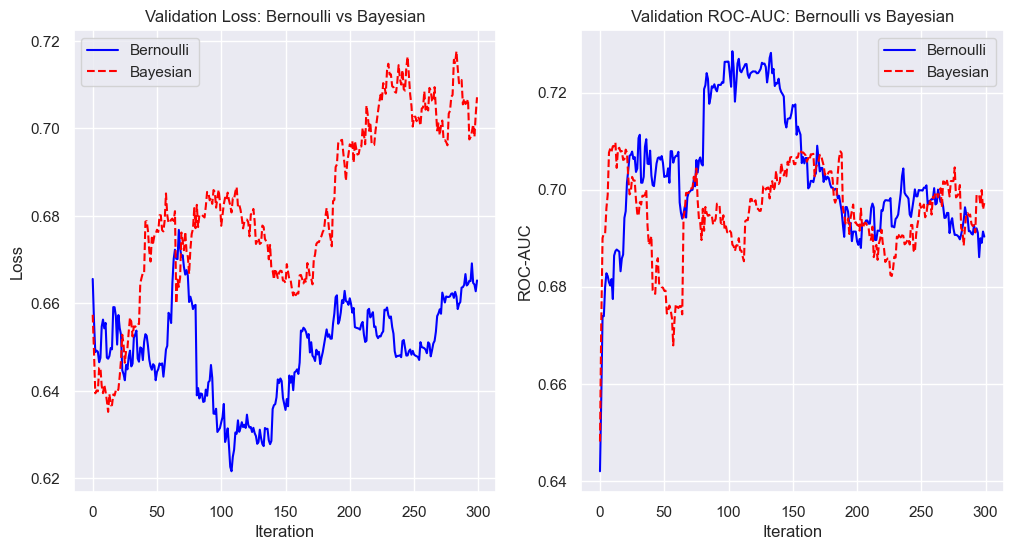

Test ROC-AUC (Bernoulli): 0.7159
Test ROC-AUC (Bayesian): 0.6968


In [64]:
N_ESTIMATORS = 300
RANDOM_SEED = 888
LR = 0.88

model_bernoulli = Boosting(
    n_estimators=N_ESTIMATORS, 
    learning_rate=LR, 
    bootstrap_type='Bernoulli',
    subsample=0.3,                
    base_model_params={'max_depth': 3, 'min_samples_leaf': 10},
    random_state=RANDOM_SEED,
    verbose=False
)

model_bayesian = Boosting(
    n_estimators=N_ESTIMATORS, 
    learning_rate=LR, 
    bootstrap_type='Bayesian',
    bagging_temperature=1.0,     
    base_model_params={'max_depth': 3, 'min_samples_leaf': 10},
    random_state=RANDOM_SEED,
    verbose=False
)

model_bernoulli.fit(X_train_enc, y_train_bin, eval_set=(X_valid_enc, y_valid_bin))

model_bayesian.fit(X_train_enc, y_train_bin, eval_set=(X_valid_enc, y_valid_bin))

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(model_bernoulli.history['val_loss'], label='Bernoulli', color='blue')
plt.plot(model_bayesian.history['val_loss'], label='Bayesian', color='red', linestyle='--')
plt.title('Validation Loss: Bernoulli vs Bayesian')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(model_bernoulli.history['val_roc_auc'], label='Bernoulli', color='blue')
plt.plot(model_bayesian.history['val_roc_auc'], label='Bayesian', color='red', linestyle='--')
plt.title('Validation ROC-AUC: Bernoulli vs Bayesian')
plt.xlabel('Iteration')
plt.ylabel('ROC-AUC')
plt.legend()
plt.grid(True)

plt.show()

score_bern = model_bernoulli.score(X_test_enc, y_test_bin)
score_bayesian = model_bayesian.score(X_test_enc, y_test_bin)

print(f"Test ROC-AUC (Bernoulli): {score_bern:.4f}")
print(f"Test ROC-AUC (Bayesian): {score_bayesian:.4f}")

Помимо выбора случайных объектов, есть идея выбирать случайное подмножество признаков, заложенная в Random Forest. Мотивация это делать точно та же самая, что и в бутстрапировании, за это будет отвечать параметр `rsm`

В библиотеках это реализовано так:

<div align="center">

| <font color="#2f82d4">XGBoost</font> | <font color="#41a657">LightGBM</font> | <font color='#d1cd3b'>CatBoost</font> |
| :---: | :---: | :---: |
| `colsample_bytree`| `colsample_bytree`| `rsm`|

</div>

Нужно добавить параметр:
- `rsm: float = 1.0` — доля признаков, участвующих в обучении модели. Каждый признак либо входит, либо не входит в пул, на котором обучается базовый алгоритм, по аналогии с бутстрапом Бернулли

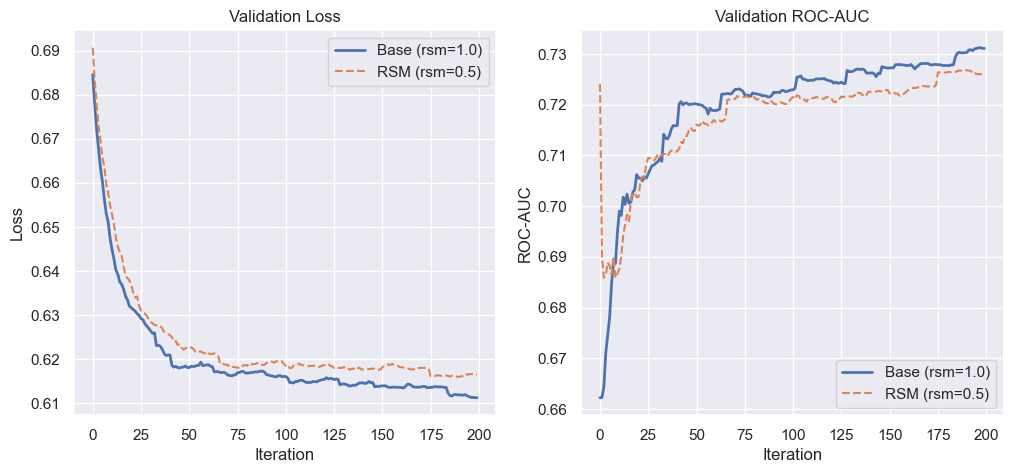


Результаты
Test ROC-AUC (Base, rsm=1.0): 0.7534
Test ROC-AUC (RSM, rsm=0.5): 0.7466


In [67]:
N_ESTIMATORS = 200

model_no_rsm = Boosting(
    n_estimators=N_ESTIMATORS, 
    learning_rate=0.1, 
    bootstrap_type='Bernoulli', 
    rsm=1.0,             
    base_model_params={'max_depth': 3, 'min_samples_leaf': 10},
    random_state=1337,
    verbose=False
)

model_rsm = Boosting(
    n_estimators=N_ESTIMATORS, 
    learning_rate=0.1, 
    bootstrap_type='Bernoulli',  
    rsm=0.5,              # 50% признаков
    base_model_params={'max_depth': 3, 'min_samples_leaf': 10},
    random_state=1337,
    verbose=False
)

model_no_rsm.fit(X_train_enc, y_train_bin, eval_set=(X_valid_enc, y_valid_bin))

model_rsm.fit(X_train_enc, y_train_bin, eval_set=(X_valid_enc, y_valid_bin))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(model_no_rsm.history['val_loss'], label='Base (rsm=1.0)', linewidth=2)
plt.plot(model_rsm.history['val_loss'], label='RSM (rsm=0.5)', linestyle='--')
plt.title('Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_no_rsm.history['val_roc_auc'], label='Base (rsm=1.0)', linewidth=2)
plt.plot(model_rsm.history['val_roc_auc'], label='RSM (rsm=0.5)', linestyle='--')
plt.title('Validation ROC-AUC')
plt.xlabel('Iteration')
plt.ylabel('ROC-AUC')
plt.legend()

plt.show()

score_no_rsm = model_no_rsm.score(X_test_enc, y_test_bin)
score_rsm = model_rsm.score(X_test_enc, y_test_bin)

print("\nРезультаты")
print(f"Test ROC-AUC (Base, rsm=1.0): {score_no_rsm:.4f}")
print(f"Test ROC-AUC (RSM, rsm=0.5): {score_rsm:.4f}")

### GOSS 

Заметим, что во время обучения не все объекты одинаково важны. Один из вариантов исправить — ввести какие-то веса на объекты, однако можно пойти и чуть хитрее. В <font color='#53c96c'>**LightGBM**</font> придумали подход [Gradient-based One-side Sampling](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf)

> Теперь оценивается важность объектов в отдельный момент обучения нового дерева. Считается, какой антиградиент привносит каждый объект. Далее градиенты разбиваются на 2 группы. Объекты с большими (по модулю) градиентами берутся все, с маленькими — только часть, по аналогии с бутстрапом. И не забываем домножить на фактор, чтобы учесть выкинутые объекты. Подробнее в статье.

Параметры, что сделаем:

- `goss: bool = False` — GOSS бустинг или нет
- `goss_k: float = 0.2` — доля объектов, градиенты которых будем считать большими. Все остальное — маленькими
- `subsample: float = 0.3` — параметры сэмплинга Бернулли для маленьких градиентов из пункта 2.3

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center">-</td>
<td align="center"><code>bagging='goss'</code></td>
<td align="center"><code>bootstrap_type='MVS'</code></td>
</tr>
</table>

</div>

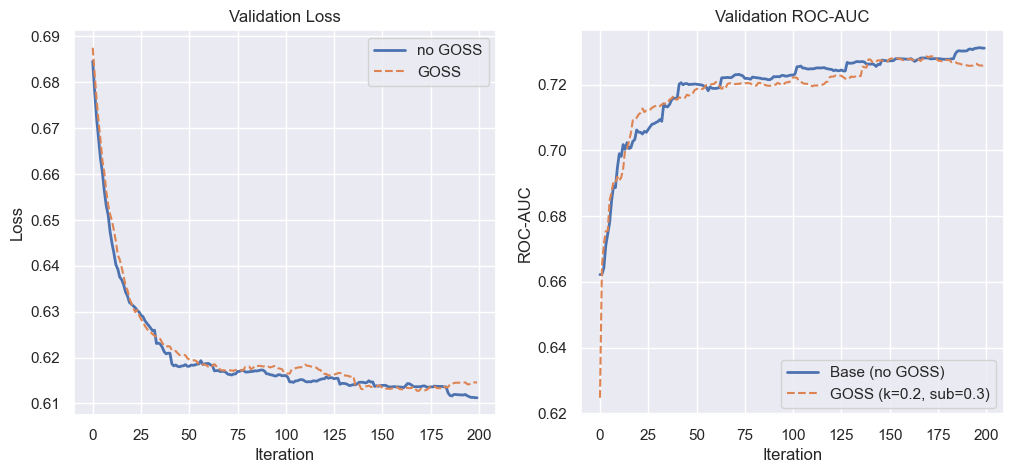


Результаты
Test ROC-AUC (no GOSS): 0.7534
Test ROC-AUC (GOSS): 0.7463


In [69]:
N_ESTIMATORS = 200

model_base = Boosting(
    n_estimators=N_ESTIMATORS, 
    learning_rate=0.1, 
    bootstrap_type=None,
    rsm=1.0,
    goss=False,
    base_model_params={'max_depth': 3, 'min_samples_leaf': 10},
    random_state=888,
    verbose=False
)


model_goss = Boosting(
    n_estimators=N_ESTIMATORS, 
    learning_rate=0.1, 
    bootstrap_type=None, 
    rsm=1.0,
    goss=True,
    goss_k=0.2, 
    subsample=0.3, 
    base_model_params={'max_depth': 3, 'min_samples_leaf': 10},
    random_state=888,
    verbose=False
)


model_base.fit(X_train_enc, y_train_bin, eval_set=(X_valid_enc, y_valid_bin))

model_goss.fit(X_train_enc, y_train_bin, eval_set=(X_valid_enc, y_valid_bin))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(model_base.history['val_loss'], label='no GOSS', linewidth=2)
plt.plot(model_goss.history['val_loss'], label='GOSS', linestyle='--')
plt.title('Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_base.history['val_roc_auc'], label='Base (no GOSS)', linewidth=2)
plt.plot(model_goss.history['val_roc_auc'], label='GOSS (k=0.2, sub=0.3)', linestyle='--')
plt.title('Validation ROC-AUC')
plt.xlabel('Iteration')
plt.ylabel('ROC-AUC')
plt.legend()

plt.show()

score_base = model_base.score(X_test_enc, y_test_bin)
score_goss = model_goss.score(X_test_enc, y_test_bin)

print("\nРезультаты")
print(f"Test ROC-AUC (no GOSS): {score_base:.4f}")
print(f"Test ROC-AUC (GOSS): {score_goss:.4f}")

### 2.4. Бинаризация 

Вместо того, чтобы выкидывать признаки, можно попробовать проредить их множество значений, применив бинаризацию. В идеале это стоит делать с датасетом до обучения модели, но не обязательно, можно, например, на этапе `fit`, а в `partial_fit` приходит уже квантизованный датасет.

> Зачем? - Квантизованные данные весят гораздо меньше, значений в них куда как меньше, а значит, наше обучение пойдет гораздо быстрее, к тому же все снова станет устойчивее. Беда лишь в новых данных, которые могут оказаться вне бина, но мне повезло с датасетом. Фактически мотивация вновь та же, что у бутстрапа.

Нужно добавить параметры:
- `quantization_type: str | None = None` — тип квантизации, если она есть
- `nbins: int = 255` — число бинов для квантизации. Игнорируем, если тип квантизации не указан

Либо сделать квантизатор отдельным классом, где в `fit` запоминаются пороги, а в `transform` преобразуются фичи

Рассмотрим варианты `quantization_type`:

- `'uniform'` — значения признака $[\min f_i, \max f_i]$ отображаются в `nbins` отрезков одинаковой длины, которые полностью покрывают интервал
- `'quantile'` — тот же самый отрезок сортируется и бьется на `nbins` квантилей от 0 до 1

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center"><code>tree_method</code></td>
<td align="center"><code>max_bin</code></td>
<td align="center"><code>quantize(...)</code></td>
</tr>
</table>

</div>

Разницу между ними можно увидеть на картинке, где квантизуется гауссиана

<img src="https://i.postimg.cc/gJ2SJgpN/image-2025-11-29-201502496.png">

Реализуем, применим их к числовым признакам.

In [73]:
from typing import Literal

class FeatureQuantizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 quantization_type: Literal['uniform', 'quantile'] | None = None, 
                 nbins: int = 255):
  
        self.quantization_type = quantization_type
        self.nbins = nbins
        self.bins_ = {}  
        self.numerical_features_indices = [] 

    def fit(self, X: np.ndarray, numerical_features_indices: list[int]):
        if self.quantization_type is None:
            return self
            
        self.numerical_features_indices = numerical_features_indices
        n_samples, n_features = X.shape

        for col_idx in self.numerical_features_indices:
            feature_data = X[:, col_idx].astype(float)
            
            feature_data = feature_data[~np.isnan(feature_data)]
            
            if len(feature_data) == 0:
                self.bins_[col_idx] = np.array([])
                continue
            
            if self.quantization_type == 'uniform':
                min_val = np.min(feature_data)
                max_val = np.max(feature_data)
                
                bins_edges = np.linspace(min_val, max_val, self.nbins + 1)[1:-1] 
                
                self.bins_[col_idx] = np.unique(bins_edges)

            elif self.quantization_type == 'quantile':
                quantiles = np.linspace(0, 1, self.nbins + 1)[1:-1] 
                
                bins_edges = np.quantile(feature_data, quantiles)
                
                self.bins_[col_idx] = np.unique(bins_edges)
            
            
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        if self.quantization_type is None:
            return X 
        
        X_quantized = X.copy()
        
        for col_idx in self.numerical_features_indices:
            if col_idx in self.bins_:
                bins_edges = self.bins_[col_idx]
                feature_data = X[:, col_idx].astype(float)

                quantized_col = np.digitize(feature_data, bins_edges, right=True)
                
                X_quantized[:, col_idx] = quantized_col.astype(int)

        return X_quantized.astype(float) 


Квантизация 'quantile'
Исходное число уникальных значений в X_train[:, 1]: 40
Квантованное число уникальных значений: 10
Пример квантованных значений: [2 3 7 6 7 0 8 0 4 9]

Квантизация 'uniform'
Исходное число уникальных значений в X_train[:, 1]: 40
Квантованное число уникальных значений: 10
Пример квантованных значений: [2 2 6 5 6 0 7 0 3 9]


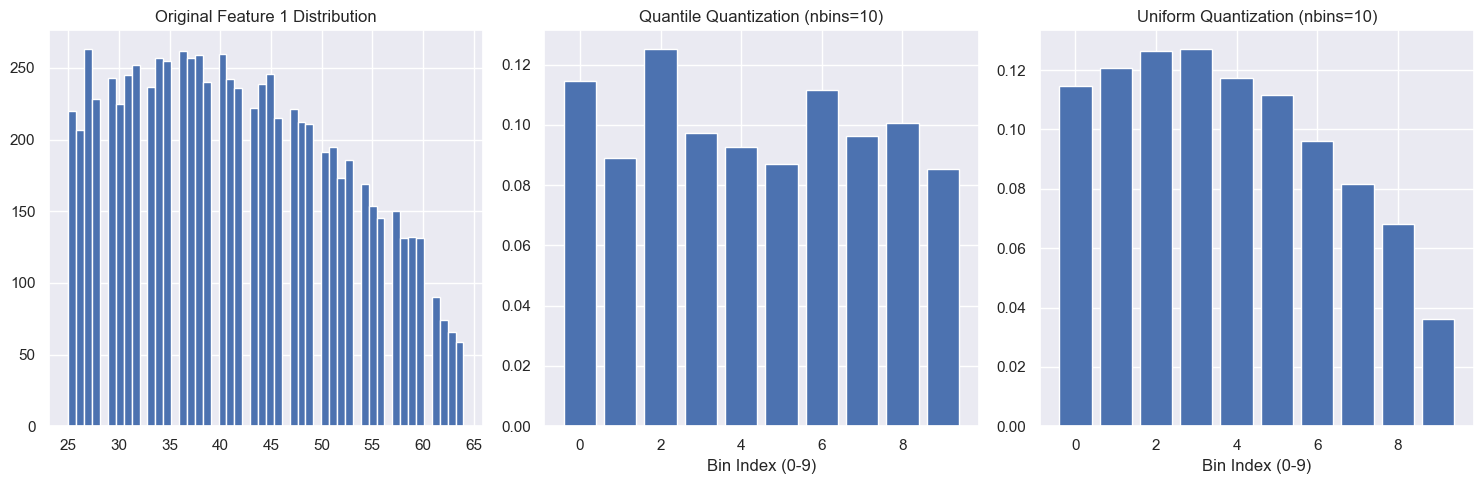

In [76]:
numerical_indices = [idx for idx in range(X_train.shape[1]) if idx not in cat_cols_indices]

quantizer_q = FeatureQuantizer(quantization_type='quantile', nbins=10) 

quantizer_q.fit(X_train, numerical_features_indices=numerical_indices)

X_train_quant_q = quantizer_q.transform(X_train_enc)
X_valid_quant_q = quantizer_q.transform(X_valid_enc)
X_test_quant_q = quantizer_q.transform(X_test_enc)

print("\nКвантизация 'quantile'")
print(f"Исходное число уникальных значений в X_train[:, {numerical_indices[0]}]: {len(np.unique(X_train_enc[:, numerical_indices[0]])):}")
print(f"Квантованное число уникальных значений: {len(np.unique(X_train_quant_q[:, numerical_indices[0]]))}")
print(f"Пример квантованных значений: {X_train_quant_q[:10, numerical_indices[0]].astype(int)}")



quantizer_u = FeatureQuantizer(quantization_type='uniform', nbins=10)

quantizer_u.fit(X_train, numerical_features_indices=numerical_indices)

X_train_quant_u = quantizer_u.transform(X_train_enc)
X_valid_quant_u = quantizer_u.transform(X_valid_enc)
X_test_quant_u = quantizer_u.transform(X_test_enc)

print("\nКвантизация 'uniform'")
print(f"Исходное число уникальных значений в X_train[:, {numerical_indices[0]}]: {len(np.unique(X_train_enc[:, numerical_indices[0]])):}")
print(f"Квантованное число уникальных значений: {len(np.unique(X_train_quant_u[:, numerical_indices[0]]))}")
print(f"Пример квантованных значений: {X_train_quant_u[:10, numerical_indices[0]].astype(int)}")


feature_to_plot = X_train[:, numerical_indices[0]]
feature_quant_q = X_train_quant_q[:, numerical_indices[0]]
feature_quant_u = X_train_quant_u[:, numerical_indices[0]]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(feature_to_plot, bins=50)
plt.title(f'Original Feature {numerical_indices[0]} Distribution')


plt.subplot(1, 3, 2)
plt.hist(feature_quant_q, bins=np.arange(11)-0.5, rwidth=0.8, density=True) 
plt.title('Quantile Quantization (nbins=10)')
plt.xlabel('Bin Index (0-9)')

plt.subplot(1, 3, 3)
plt.hist(feature_quant_u, bins=np.arange(11)-0.5, rwidth=0.8, density=True)
plt.title('Uniform Quantization (nbins=10)')
plt.xlabel('Bin Index (0-9)')

plt.tight_layout()
plt.show()

<font color='#b962c4'>**1**: Квантизация, в частности 'quantile', очень хороша для борьбы с выбросами: она отправляет все значения, выходящие за пределы типичного диапазона, в самый крайний бин. Это помогает модели решить проблему масштабирования признаков, сделав обучение более устойчивым. Касаемо нанов, для них можно выделить отдельный индекс бина, что поможет их корректно обработать, сохранив информацию о пропуске значения. </font>

<font color='#b962c4'>**2**: Также в бустинге на решающих деревьях наны часто заполняют числом. С точки зрения логики дерева размер числа не окажет сильного влияния, но использование слишком экстремальных значений будет возможно только с квантизацией. </font>

### Квантизация 

В современных имплементациях бустинга используются более сложные методы квантизации. К сожалению, способы выше страдают либо от неравноправности бинов — в каких-то объектов больше, в каких-то меньше, в каких-то значения повторяются, в каких-то нет, либо от того, что целевая переменная от бинов зависит опосредованно, да и пороги берутся с потолка

Есть два необычных подхода:

1. $\text{MinEntropy}$. Это [один из методов](https://catboost.ai/docs/en/concepts/quantization), который используется для бинаризации в <font color='#c4bf0a'>**CatBoost**</font>, остальные на него очень похожи. В нем жадно набирают бины так, чтобы суммарная побиновая энтропия объектов ($\sum_{i \in \text{bin}} x_i\log(x_i)$) была как можно меньше. Это, правда, предполагает, что значения числовых фичей могут повторяться, и так и есть в части наших колонок
   
2. $\text{PiecewiseEncoding}$. Это относительно свежий метод для [табличных трансформеров](https://arxiv.org/pdf/2203.05556). Суть заключается в том, что бины для квантизации берутся не с потолка, а именно те, что нужны для разбиения таргета через максимизацию InfoGain \
NB: В статье делается кодирование в вектор длины $T$, где $T$ число бинов, в нашем случае это излишне, бинов можно оставить столько же, но взять лишь закодированную по формуле часть

Оба метода на самом деле похожи, поэтому выбирайте на свой вкус. Оба пытаются подобрать пороги при помощи некоторого алгоритма, который тоже работает с энтропией или InfoGain. В библиотеках способы реализации чуть отличаются, и предлагаемый способ не единственный.

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center">-</td>
<td align="center">-</td>
<td align="center"><code>feature_border_type="Piecewise"</code></td>
</tr>
</table>

</div>

Добавим, например, `'min_entropy'` (ещё можно `'piecewise'`) для `quantization_type`.

In [80]:
class FeatureQuantizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 quantization_type: Literal['uniform', 'quantile', 'min_entropy'] | None = None, 
                 nbins: int = 255):
        self.quantization_type = quantization_type
        self.nbins = nbins
        self.bins_ = {} 
        self.numerical_features_indices = []

    def _entropy(self, y: np.ndarray) -> float:
        if len(y) == 0:
            return 0.0
        
        p1 = np.mean(y) 
        p0 = 1.0 - p1   
        
        entropy = 0.0
        if p1 > 0:
            entropy -= p1 * np.log2(p1)
        if p0 > 0:
            entropy -= p0 * np.log2(p0)
            
        return entropy

    def _find_best_split(self, X_sorted: np.ndarray, y_sorted: np.ndarray) -> tuple[float, float, int]:
        n_samples = len(y_sorted)
        min_entropy = float('inf')
        best_threshold = None
        best_split_idx = -1

        for i in range(1, n_samples):
            if X_sorted[i] == X_sorted[i-1]:
                continue
            
            y_left = y_sorted[:i]
            y_right = y_sorted[i:]
            
            e_left = self._entropy(y_left)
            e_right = self._entropy(y_right)
            
            weighted_entropy = (len(y_left) / n_samples) * e_left + (len(y_right) / n_samples) * e_right
            
            if weighted_entropy < min_entropy:
                min_entropy = weighted_entropy
                best_threshold = (X_sorted[i] + X_sorted[i-1]) / 2.0
                best_split_idx = i
                
        return min_entropy, best_threshold, best_split_idx

    def _recursive_split(self, X_sorted: np.ndarray, y_sorted: np.ndarray, current_bins: list):
        if len(current_bins) >= self.nbins - 1:
            return
    
        if len(y_sorted) < 2:
            return

        if np.all(y_sorted == y_sorted[0]):
            return
            
        if np.all(X_sorted == X_sorted[0]):
            return
            
        _, best_threshold, best_split_idx = self._find_best_split(X_sorted, y_sorted)

        if best_threshold is None or best_split_idx == -1:
            return

        current_bins.append(best_threshold)
        
        X_left, y_left = X_sorted[:best_split_idx], y_sorted[:best_split_idx]
        X_right, y_right = X_sorted[best_split_idx:], y_sorted[best_split_idx:]
        
        if len(X_left) > len(X_right):
            self._recursive_split(X_left, y_left, current_bins)
            self._recursive_split(X_right, y_right, current_bins)
        else:
            self._recursive_split(X_right, y_right, current_bins)
            self._recursive_split(X_left, y_left, current_bins)
            
    def fit(self, X: np.ndarray, y: np.ndarray, numerical_features_indices: list[int]):
        if self.quantization_type is None:
            return self
            
        self.numerical_features_indices = numerical_features_indices
        self.bins_ = {}
        
        for col_idx in self.numerical_features_indices:
            data = pd.DataFrame({'X': X[:, col_idx], 'y': y})
            data = data.dropna()
            data = data.sort_values(by='X').reset_index(drop=True)
            
            X_sorted = data['X'].values.astype(float)
            y_sorted = data['y'].values.astype(float)
            
            current_bins = []
            
            if self.quantization_type == 'min_entropy':
                self._recursive_split(X_sorted, y_sorted, current_bins)
                
                final_bins = np.unique(np.sort(current_bins))
                
            elif self.quantization_type == 'uniform':
                min_val = np.min(X_sorted)
                max_val = np.max(X_sorted)
                final_bins = np.unique(np.linspace(min_val, max_val, self.nbins + 1)[1:-1])
                
            elif self.quantization_type == 'quantile':
                quantiles = np.linspace(0, 1, self.nbins + 1)[1:-1]
                final_bins = np.unique(np.quantile(X_sorted, quantiles))
            

            self.bins_[col_idx] = final_bins

        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        if self.quantization_type is None:
            return X 
        
        X_quantized = X.copy()
        
        for col_idx in self.numerical_features_indices:
            if col_idx in self.bins_:
                bins_edges = self.bins_[col_idx]
                feature_data = X[:, col_idx].astype(float)
                
                quantized_col = np.digitize(feature_data, bins_edges, right=True)
                
                X_quantized[:, col_idx] = quantized_col.astype(int)
        
        return X_quantized.astype(float)

Обучение 'min_entropy' квантизатора на 6 признаках

Квантизация 'min_entropy' (nbins=10)
Исходное число уникальных значений: 40
Квантованное число уникальных значений: 10
Пример квантованных значений: [0 1 8 8 8 0 9 0 3 9]


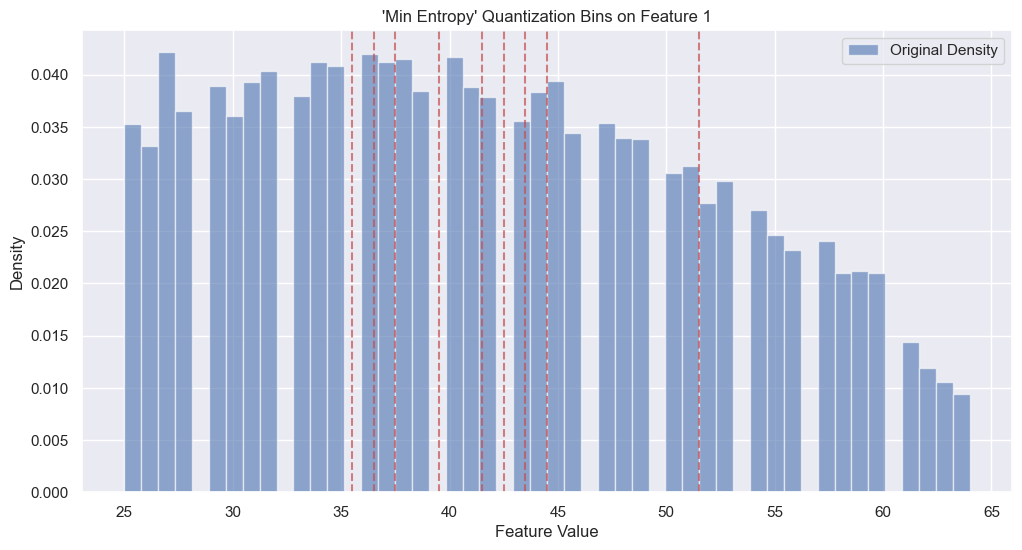


Сравнение ROC-AUC
Test ROC-AUC (Base, без квантизации): 0.7361
Test ROC-AUC (Min Entropy, nbins=10): 0.7232


In [82]:
numerical_indices = [idx for idx in range(X_train.shape[1]) if idx not in cat_cols_indices]

    
NBINS_ENTROPY = 10 
quantizer_ent = FeatureQuantizer(quantization_type='min_entropy', nbins=NBINS_ENTROPY) 

print(f"Обучение 'min_entropy' квантизатора на {len(numerical_indices)} признаках")
quantizer_ent.fit(X_train_enc, y_train_bin, numerical_features_indices=numerical_indices)

X_train_quant_ent = quantizer_ent.transform(X_train_enc)
X_valid_quant_ent = quantizer_ent.transform(X_valid_enc)
X_test_quant_ent = quantizer_ent.transform(X_test_enc)

first_num_idx = numerical_indices[0]
print("\nКвантизация 'min_entropy' (nbins=10)")
print(f"Исходное число уникальных значений: {len(np.unique(X_train_enc[:, first_num_idx]))}")
print(f"Квантованное число уникальных значений: {len(np.unique(X_train_quant_ent[:, first_num_idx]))}")
print(f"Пример квантованных значений: {X_train_quant_ent[:10, first_num_idx].astype(int)}")

feature_to_plot = X_train_enc[:, first_num_idx]
quantized_feature = X_train_quant_ent[:, first_num_idx]
bins_edges = quantizer_ent.bins_[first_num_idx]

plt.figure(figsize=(12, 6))

plt.hist(feature_to_plot, bins=50, density=True, alpha=0.6, label='Original Density')
for edge in bins_edges:
    plt.axvline(edge, color='r', linestyle='--', alpha=0.7)
    
plt.title(f"'Min Entropy' Quantization Bins on Feature {first_num_idx}")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.legend()
plt.show()


N_ESTIMATORS = 50
model_base = Boosting(
    n_estimators=N_ESTIMATORS,
    learning_rate=0.1,
    bootstrap_type=None,
    goss=True,          
    goss_k=0.2,
    subsample=0.3,
    rsm=1.0,              
    base_model_params={'max_depth': 3, 'min_samples_leaf': 10},
    random_state=888,
    verbose=False
)


model_ent = Boosting(
    n_estimators=N_ESTIMATORS,
    learning_rate=LR,
    bootstrap_type=None,
    goss=True,          
    goss_k=0.2,
    subsample=0.3,
    rsm=1.0,             
    base_model_params={'max_depth': 3, 'min_samples_leaf': 10},
    random_state=888,
    verbose=False
)


model_base.fit(X_train_enc, y_train_bin, eval_set=(X_valid_enc, y_valid_bin))

model_ent.fit(X_train_quant_ent, y_train_bin, eval_set=(X_valid_quant_ent, y_valid_bin))

score_base = model_base.score(X_test_enc, y_test_bin)
score_ent = model_ent.score(X_test_quant_ent, y_test_bin)

print("\nСравнение ROC-AUC")
print(f"Test ROC-AUC (Base, без квантизации): {score_base:.4f}")
print(f"Test ROC-AUC (Min Entropy, nbins={NBINS_ENTROPY}): {score_ent:.4f}")

### 2.5. Важность признаков 

Поскольку наша базовая модель — это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и взвешенно усреднить (воспользуемся `feature_importances_` у `DecisionTreeRegressor` и знанием о гаммах), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными — иначе вы что-то сделали не так). Разумеется, способ не единственный.
Допишем к бустингу:
- `feature_importances_` — атрибут, который возвращает важность признаков, согласно методу выше

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center"><code>model.get_score()</code></td>
<td align="center"><code>lightgbm.importance()</code></td>
<td align="center"><code>model.get_feature_importance()</code></td>
</tr>
</table>

</div>

Отобразим признаки, что оказались самыми важными


Топ-10 самых важных признаков:
       Feature  Importance
0       region    0.115928
5      empstat    0.112784
3         race    0.096960
8       annhrs    0.094447
11  occupation    0.092964
4          sch    0.091498
10     incwage    0.078929
2         year    0.078666
7          ind    0.069707
6          occ    0.065504


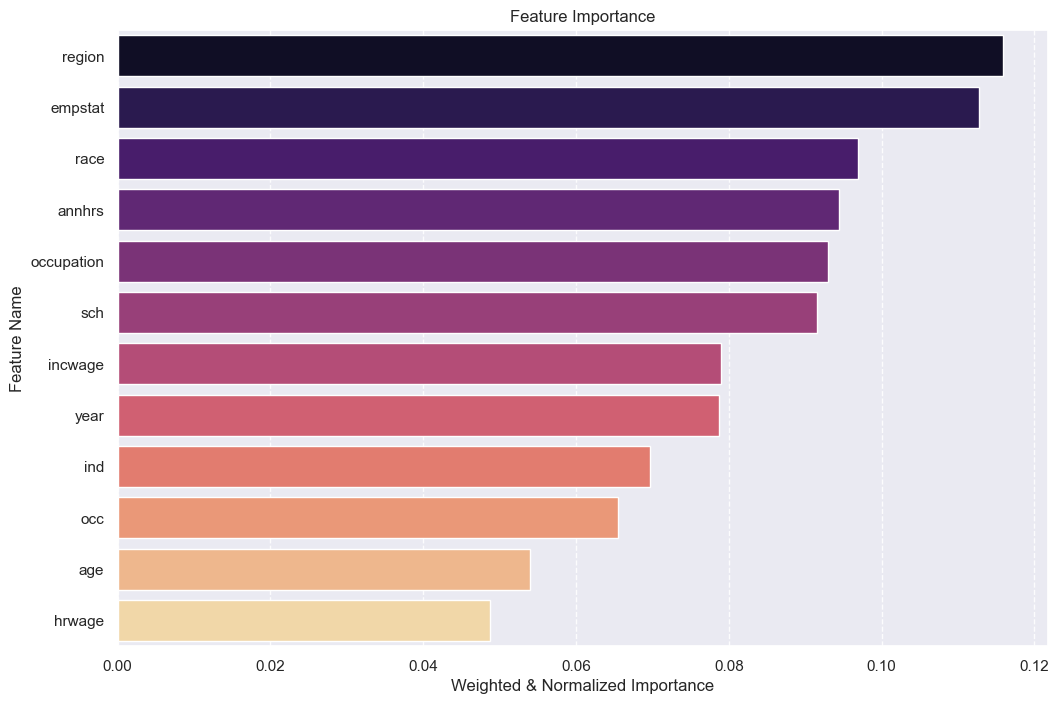

In [97]:
model_ent = Boosting(
    n_estimators=200,
    learning_rate=0.1,
    bootstrap_type=None,
    goss=True,          
    goss_k=0.2,
    subsample=0.3,
    rsm=1.0,             
    base_model_params={'max_depth': 3, 'min_samples_leaf': 10},
    random_state=888,
    verbose=False
)


model_ent.fit(X_train_quant_ent, y_train_bin, eval_set=(X_valid_quant_ent, y_valid_bin))
feature_names = df.drop("sex", axis=1).columns.tolist()
importances = model_ent.feature_importances_

df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nТоп-10 самых важных признаков:")
print(df_imp.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_imp.head(20), 
    x='Importance', 
    y='Feature', 
    hue='Feature',
    palette='magma', 
    legend=False
)
plt.title('Feature Importance')
plt.xlabel('Weighted & Normalized Importance')
plt.ylabel('Feature Name')
plt.grid(axis='x', linestyle='--', alpha=0.88)
plt.show()

### DART 

Ранее отмечалось, что каждый базовый алгоритм пытается исправить ошибки всего предыдущего ансамбля. Из-за этого возникает неравноправие — каждая новая модель вносит все меньший и меньший вклад. Уверенные обучатели нейросетей знают, что это может привести к переобучению, если проводить аналогию с весами. Но выход есть, и выход этот [DART](https://arxiv.org/pdf/1505.01866)!

> В DL есть такой вид регуляризации, как dropout, когда некоторые узлы нейросети со случайным шансом отключаются. Можно попробовать обобщить этот подход на случай бустингов и случайно выкидывать деревья из композиции во время обучения

1. Выбираем, какие деревья убрать. При подсчете антиградиента берем не весь ансамбль, а только ту часть, что осталась
2. Домножаем выходы дерева на $1/k$, где $k$ — число удаленных деревьев, чтобы учесть тот факт, что ансамбль был не весь. Тогда вклад отдельного дерева будет не настолько большим
3. Домножаем выходы выкинутых деревьев на $k/(k+1)$, чтобы масштабы выходов примерно совпадали

Параметры, которые добавляются:

- `dart: bool = False` — DART бустинг или нет
- `dropout_rate: float = 0.05` — доля деревьев, которую выкидываем во время обучения DART

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center"><code>XGBClassifier(booster="dart")</code></td>
<td align="center"><code>LGBMClassifier(boosting_type="dart")</code></td>
<td align="center">-</td>
</tr>
</table>

</div>

Обучим DART на наших данных. 

ROC AUC на валидации c DART: 0.6228

Топ-10 самых важных признаков:
       Feature  Importance
10     incwage    0.161833
8       annhrs    0.121479
9       hrwage    0.113313
4          sch    0.100665
0       region    0.094351
1          age    0.079612
2         year    0.075735
3         race    0.064084
11  occupation    0.058857
5      empstat    0.056040


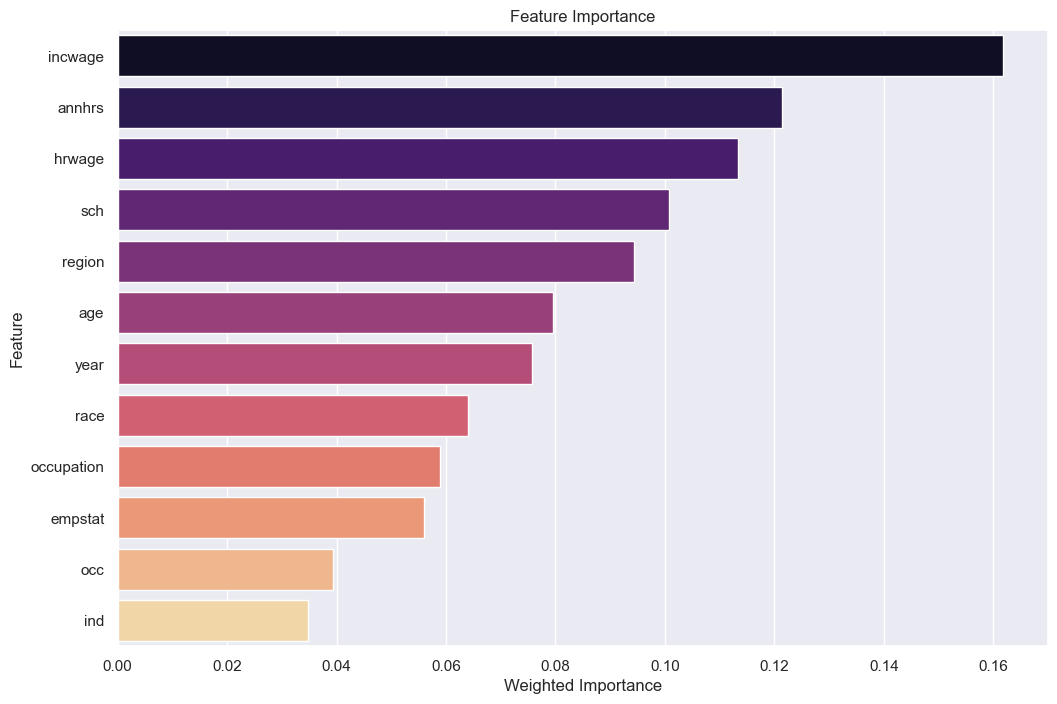

In [100]:
dart_model = Boosting(
    base_model_params={'max_depth': 3, 'min_samples_leaf': 10},
    n_estimators=100,
    learning_rate=0.88,
    rsm=1.0,               
    subsample=0.3,
    dart=True,              
    dropout_rate=0.05,      
    random_state=888,
    verbose=True
)


dart_model.fit(X_train_enc, y_train_bin, eval_set=(X_valid_enc, y_valid_bin))


val_score_dart = dart_model.score(X_valid_quant_ent, y_valid_bin)
print(f"ROC AUC на валидации c DART: {val_score_dart:.4f}")

importances = dart_model.feature_importances_

df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nТоп-10 самых важных признаков:")
print(df_imp.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_imp.head(20), 
    x='Importance', 
    y='Feature', 
    hue='Feature',
    palette='magma', 
    legend=False
)
plt.title('Feature Importance')
plt.xlabel('Weighted Importance')
plt.ylabel('Feature')
plt.show()

------
## 3. 
Проанализируем, как правильно готовить бустинги. Нас интересует: как тюнить бустинги, какие бывают и как их интерпретировать. 

### 3.1. Optuna 

Подберем на валидации оптимальные значения следующих гиперпараметров для реализации бустинга:
- `max_depth`
- `n_estimators`
- `learning_rate`

Посмотрим на оптимальный набор параметров. 

[I 2025-12-19 23:24:26,345] A new study created in memory with name: boosting_tuning


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-19 23:24:29,373] Trial 0 finished with value: 0.7280249120996485 and parameters: {'max_depth': 3, 'n_estimators': 123, 'learning_rate': 0.06198994421413723}. Best is trial 0 with value: 0.7280249120996485.
Stop at 91. Best: 82, Score: 0.7184408737634951
[I 2025-12-19 23:24:31,339] Trial 1 finished with value: 0.7184408737634951 and parameters: {'max_depth': 3, 'n_estimators': 140, 'learning_rate': 0.05366429058121804}. Best is trial 0 with value: 0.7280249120996485.
Stop at 23. Best: 14, Score: 0.7274769099076397
[I 2025-12-19 23:24:31,858] Trial 2 finished with value: 0.7274769099076397 and parameters: {'max_depth': 3, 'n_estimators': 83, 'learning_rate': 0.32253167315963255}. Best is trial 0 with value: 0.7280249120996485.
Stop at 25. Best: 16, Score: 0.6519286077144308
[I 2025-12-19 23:24:32,138] Trial 3 finished with value: 0.6519286077144308 and parameters: {'max_depth': 1, 'n_estimators': 115, 'learning_rate': 0.013812148774782153}. Best is trial 0 with value: 0.728024

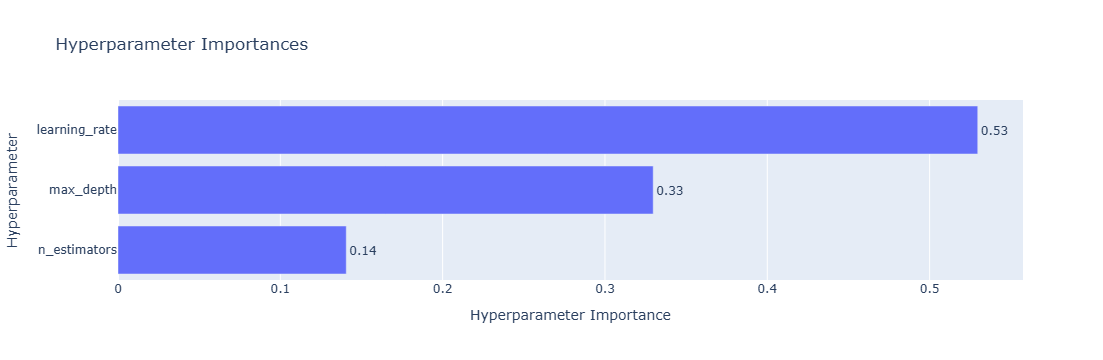

In [104]:
import optuna
from optuna.visualization import plot_param_importances, plot_optimization_history
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 1, 8)
    n_estimators = trial.suggest_int("n_estimators", 20, 150)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)

    model_enc = Boosting(
        base_model_params={
            'max_depth': max_depth,
            'min_samples_leaf': 10
        },
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=888,
        early_stopping_rounds=10,
        eval_metric='val_roc_auc',
        verbose=True
    )

    model_enc.fit(
        X_train_enc, y_train_bin,
        eval_set=(X_valid_enc, y_valid_bin),
        use_best_model=True
    )

    score = model_enc.score(X_valid_enc, y_valid_bin)
    return score


study = optuna.create_study(
    direction="maximize",
    study_name="boosting_tuning",
    load_if_exists=True
)

study.optimize(objective, n_trials=30, show_progress_bar=True)

print(f"\nBest ROC-AUC: {study.best_value:.5f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

fig = plot_param_importances(study)
fig.show()

Запуск дообучения, начиная с параметров: {'max_depth': 5, 'n_estimators': 105, 'learning_rate': 0.1678570112763637}


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-19 21:32:33,105] Trial 40 finished with value: 0.8471393885575543 and parameters: {'max_depth': 5, 'n_estimators': 105, 'learning_rate': 0.1678570112763637}. Best is trial 15 with value: 0.8511534046136184.
[I 2025-12-19 21:32:34,064] Trial 41 finished with value: 0.8509114036456146 and parameters: {'max_depth': 4, 'n_estimators': 63, 'learning_rate': 0.12587410126183188}. Best is trial 15 with value: 0.8511534046136184.
[I 2025-12-19 21:32:34,771] Trial 42 finished with value: 0.8483013932055727 and parameters: {'max_depth': 3, 'n_estimators': 72, 'learning_rate': 0.19175327874053436}. Best is trial 15 with value: 0.8511534046136184.
[I 2025-12-19 21:32:35,665] Trial 43 finished with value: 0.8497333989335957 and parameters: {'max_depth': 4, 'n_estimators': 60, 'learning_rate': 0.24642401475647763}. Best is trial 15 with value: 0.8511534046136184.
[I 2025-12-19 21:32:36,751] Trial 44 finished with value: 0.8500374001496006 and parameters: {'max_depth': 3, 'n_estimators': 84

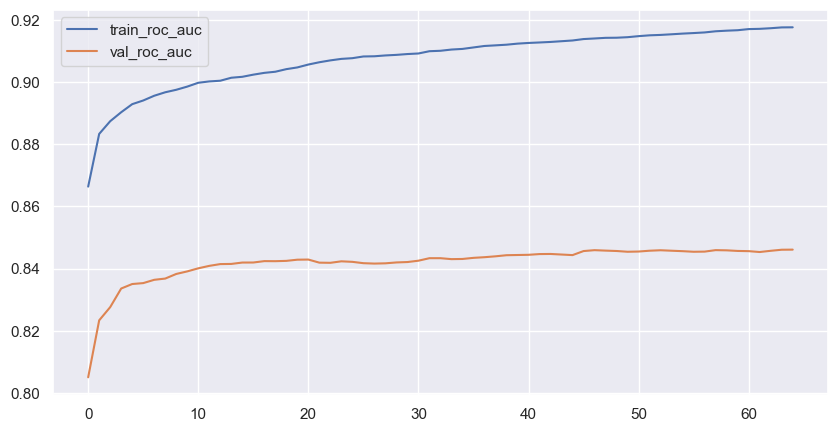

In [520]:
initial_best_params = {'max_depth': 5, 'n_estimators': 105, 'learning_rate': 0.1678570112763637}

study.enqueue_trial(initial_best_params)

print(f"Запуск дообучения, начиная с параметров: {initial_best_params}")
study.optimize(objective, n_trials=10, show_progress_bar=True)

best_params = study.best_params
best_quality = study.best_value

print("\nОбновленные результаты Optuna")
print(f"Лучший ROC-AUC (на валидации): {best_quality:.5f}")
print(f"Новые лучшие параметры: {best_params}")

final_model = Boosting(
    base_model_params={
        'max_depth': best_params['max_depth'],
        'min_samples_leaf': 10
    },
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    bootstrap_type=None, 
    goss=True,           
    goss_k=0.2,          
    subsample=0.1,       
    random_state=888,
    verbose=False
)

final_model.fit(
    X_train_enc, 
    y_train_bin, 
    eval_set=(X_valid_enc, y_valid_bin),
    use_best_model=True
)


test_score = final_model.score(X_test_enc, y_test_bin)

print(f"ROC-AUC на тестовой выборке: {test_score:.5f}")

final_model.plot_history(keys=['train_roc_auc', 'val_roc_auc'])

### 3.2. Глубокая оптимизация 

Помимо эффективного перебора гиперпараметров, `optuna` предлагает более тонкий контроль над самой процедурой обучения

1. Будем контролировать процесс обучения бустинга при помощи прунера. У библиотечных имплементаций есть уже готовые. Для кастомной модели возьмём что-то из [`optuna.pruners`](https://optuna.readthedocs.io/en/stable/reference/pruners.html). Идея прунера — не обучать бустинг до конца, если по истории валидации видно, что другие бустинги на этом этапе статистически лучше, для этого помогает ранее написанный `partial_fit`.
2. Если мы ценим наше время, можно внести в процесс оптимизации немного определенности и, например, сказать, что если мы достигли определенного качества, то этого нам уже хватит с головой. Объект со смешным названием [`optuna.terminator`](https://optuna.readthedocs.io/en/stable/reference/terminator.html) позволяет нам остановить оптимизацию по достижении некоторого трешхолда по какому-либо параметру, который мы сами придумали, например, качестве на тесте

Также:
1. Добавим другие параметры, которые были реализовали ранее, в `objective`.
2. Попробуем ускорить оптимизацию при помощи прунера или терминатора. 
3. Не будем забывать, что лучшим трайалом может быть что-то из топ-10, а не только из топ-1

[I 2025-12-19 22:33:11,199] A new study created in memory with name: no-name-cdfe7bef-ed36-4cd7-95d9-37942be7d06b


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-12-19 22:33:13,473] Trial 0 finished with value: 0.7086183044479117 and parameters: {'max_depth': 5, 'n_estimators': 105, 'learning_rate': 0.1678570112763637, 'goss': True, 'goss_k': 0.2, 'subsample': 0.1, 'rsm': 1.0}. Best is trial 0 with value: 0.7086183044479117.
[I 2025-12-19 22:33:16,470] Trial 1 finished with value: 0.7259836779328083 and parameters: {'max_depth': 5, 'n_estimators': 386, 'learning_rate': 0.049434969554518045, 'goss': False, 'subsample': 0.5496313631817021, 'rsm': 0.782174186069501}. Best is trial 1 with value: 0.7259836779328083.
[I 2025-12-19 22:33:20,194] Trial 2 finished with value: 0.7094312011598127 and parameters: {'max_depth': 3, 'n_estimators': 140, 'learning_rate': 0.012771813817807181, 'goss': False, 'subsample': 0.7176772849724133, 'rsm': 0.865274184875759}. Best is trial 1 with value: 0.7259836779328083.
[I 2025-12-19 22:33:22,842] Trial 3 finished with value: 0.7146060301740523 and parameters: {'max_depth': 9, 'n_estimators': 118, 'learning_r

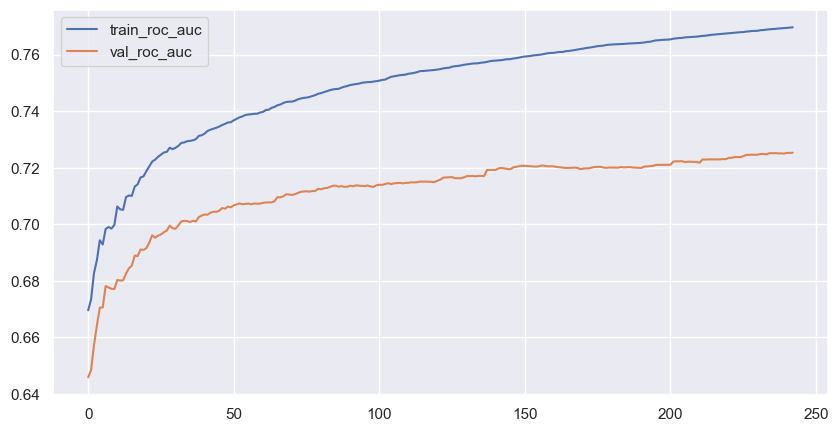

In [552]:
from sklearn.model_selection import StratifiedKFold
from optuna.pruners import MedianPruner
from optuna.trial import TrialState

class ThresholdCallback:
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, study, trial):
        if trial.state == TrialState.COMPLETE and trial.value is not None:
            if trial.value >= self.threshold:
                print(f"\n[Terminator] Порог {self.threshold} пройден. Останавливаем поиск.")
                study.stop()

def objective(trial):
    max_depth = trial.suggest_int("max_depth", 2, 10)
    n_estimators = trial.suggest_int("n_estimators", 100, 600)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    
    goss = trial.suggest_categorical("goss", [True, False])
    
    if goss:
        goss_k = trial.suggest_float("goss_k", 0.05, 0.4)
        subsample = trial.suggest_float("subsample", 0.05, 0.4) 
    else:
        goss_k = 0.2 
        subsample = trial.suggest_float("subsample", 0.4, 1.0) 
    
    rsm = trial.suggest_float("rsm", 0.7, 1.0) 

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=888)
    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_enc, y_train_bin)):
        X_f_train, X_f_val = X_train_enc[train_idx], X_train_enc[val_idx]
        y_f_train, y_f_val = y_train_bin[train_idx], y_train_bin[val_idx]
        
        model = Boosting(
            base_model_params={'max_depth': max_depth, 'min_samples_leaf': 10},
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            goss=goss,
            goss_k=goss_k,
            subsample=subsample,
            rsm=rsm,
            random_state=888,
            early_stopping_rounds=15, 
            verbose=False
        )

        model.fit(X_f_train, y_f_train, eval_set=(X_f_val, y_f_val), use_best_model=True)
        
        fold_score = max(model.history['val_roc_auc']) if model.history['val_roc_auc'] else 0
        cv_scores.append(fold_score)

        trial.report(np.mean(cv_scores), step=fold)
        
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(cv_scores)



study = optuna.create_study(
    direction="maximize", 
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=0)
)

initial_params = {
    'max_depth': 5, 
    'n_estimators': 105, 
    'learning_rate': 0.1678570112763637,
    'goss': True,
    'goss_k': 0.2,
    'subsample': 0.1,
    'rsm': 1.0
}
study.enqueue_trial(initial_params)


terminator = ThresholdCallback(threshold=0.84) 


study.optimize(objective, n_trials=40, callbacks=[terminator], show_progress_bar=True)

best_p = study.best_params
print(f"\nЛучшие параметры: {best_p}")

final_model = Boosting(
    base_model_params={'max_depth': best_p['max_depth'], 'min_samples_leaf': 10},
    n_estimators=best_p['n_estimators'],
    learning_rate=best_p['learning_rate'],
    goss=best_p['goss'],
    goss_k=best_p.get('goss_k', 0.2),
    subsample=best_p['subsample'],
    rsm=best_p.get('rsm', 1.0),
    random_state=888
)

final_model.fit(X_train_enc, y_train_bin, eval_set=(X_valid_enc, y_valid_bin), use_best_model=True)

test_auc = final_model.score(X_test_enc, y_test_bin)
print(f"Итоговый ROC-AUC на тесте: {test_auc:.5f}")
final_model.plot_history(keys=['train_roc_auc', 'val_roc_auc'])

### 3.3. Готовые реализации 

Библиотек для бустингов много, но активно используются лишь три. 

<font color='#2f82d4'>XGBoost</font>, <font color='#53c96c'>LightGBM</font> или <font color='#c4bf0a'>CatBoost</font>.

Возьмем CatBoost, подобрем те же оптимальные параметры, что и выше, и сравнить две оптимизированные модели по
- динамике функции потерь (на обучающей и на валидационной выборке)
- времени обучения
- оптимальному набору гиперпараметров

[I 2025-12-19 23:26:35,328] A new study created in memory with name: no-name-f268f60d-de54-4796-a3a1-beb0dbb8f13c
[I 2025-12-19 23:26:35,637] Trial 0 finished with value: 0.714182856731427 and parameters: {'iterations': 99, 'depth': 3, 'learning_rate': 0.08678391991627367, 'subsample': 0.6132902923202834}. Best is trial 0 with value: 0.714182856731427.
[I 2025-12-19 23:26:35,797] Trial 1 finished with value: 0.7015928063712256 and parameters: {'iterations': 60, 'depth': 5, 'learning_rate': 0.019166739746157523, 'subsample': 0.689382077460443}. Best is trial 0 with value: 0.714182856731427.
[I 2025-12-19 23:26:36,485] Trial 2 finished with value: 0.7102388409553638 and parameters: {'iterations': 268, 'depth': 4, 'learning_rate': 0.010127248876754568, 'subsample': 0.8432471786568737}. Best is trial 0 with value: 0.714182856731427.
[I 2025-12-19 23:26:37,029] Trial 3 finished with value: 0.7311349245396981 and parameters: {'iterations': 297, 'depth': 7, 'learning_rate': 0.0561720224551545

Custom Model Time: 0.3130 sec | Test AUC: 0.7353
CatBoost Time:     0.6307 sec | Test AUC: 0.7473


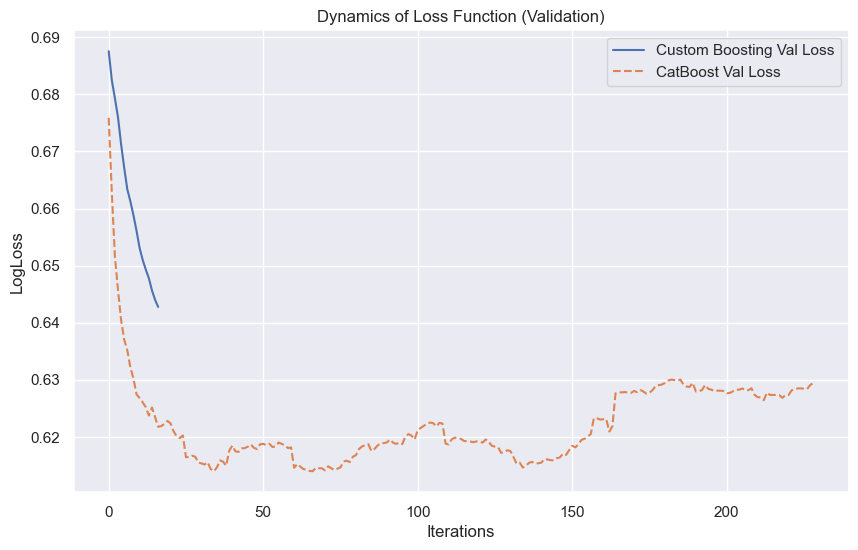

In [106]:
from catboost import CatBoostClassifier

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 1, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'bootstrap_type': 'Bernoulli', 
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'logging_level': 'Silent',
        'eval_metric': 'AUC',
        'random_seed': 888
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train_enc, y_train_bin, 
              eval_set=(X_valid_enc, y_valid_bin), 
              early_stopping_rounds=20)
    return model.best_score_['validation']['AUC']

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_catboost, n_trials=30)

best_custom_params = {
    'max_depth': 7,
    'n_estimators': 311,
    'learning_rate': 0.05378016209618279,
    'min_samples_leaf': 21,
    'rsm': 1,
    'subsample': 0.3817029782865779
}

final_model = Boosting(
    base_model_params={
        'max_depth': best_custom_params['max_depth'],
        'min_samples_leaf': best_custom_params['min_samples_leaf']
    },
    n_estimators=best_custom_params['n_estimators'],
    learning_rate=best_custom_params['learning_rate'],
    rsm=best_custom_params['rsm'],             
    subsample=best_custom_params['subsample'], 
    goss=False,                                       
    early_stopping_rounds=10, 
    random_state=111,
    verbose=False
)


start_time = time.time()
final_model.fit(X_train_enc, y_train_bin, eval_set=(X_valid_enc, y_valid_bin))
custom_time = time.time() - start_time
custom_auc = final_model.score(X_test_enc, y_test_bin)

best_cb_params = study_cb.best_params.copy()
best_cb_params.update({
    'logging_level': 'Silent', 
    'eval_metric': 'Logloss', 
    'random_seed': 888,
})

cb_model = CatBoostClassifier(**best_cb_params)
start_time = time.time()
cb_model.fit(X_train_enc, y_train_bin, eval_set=(X_valid_enc, y_valid_bin))
cb_time = time.time() - start_time

cb_probs = cb_model.predict_proba(X_test_enc)[:, 1]
cb_auc = roc_auc_score(y_test_bin, cb_probs)

print(f"Custom Model Time: {custom_time:.4f} sec | Test AUC: {custom_auc:.4f}")
print(f"CatBoost Time:     {cb_time:.4f} sec | Test AUC: {cb_auc:.4f}")

plt.figure(figsize=(10, 6))
if 'val_loss' in final_model.history:
    plt.plot(final_model.history['val_loss'], label='Custom Boosting Val Loss')

cb_loss_history = cb_model.evals_result_['validation']['Logloss']
plt.plot(cb_loss_history, label='CatBoost Val Loss', linestyle='--')

plt.title('Dynamics of Loss Function (Validation)')
plt.xlabel('Iterations')
plt.ylabel('LogLoss')
plt.legend()
plt.grid(True)
plt.show()

<font color='#b962c4'> Собственная архитектура, конечно, поприятнее с большим количеством возможностей ручного вмешательства в подбор гиперпараметров, свое всегда можно подкрутить и проходит оно более контролируемо, хоть не всегда сравнимо по экономии времени с готовыми реализациями.</font>

### Еще пара красивых слов 


- <font color='#2f82d4'>XGBoost</font> известен тем, что в нем впервые повилась регуляризация. При его использовании можно было бы добавить обе регуляризации, что там есть, как параметры в оптуну и прогнать процесс оптимизации только на них. Стоит отметить, что регуляризация деревьев это грубая сила. Мы просто запрещаем дереву становиться слишком сложным. В то время как прямая регуляризация (Ridge; Lasso), пришедшая в бустинг из регрессионных моделей, позволяет дереву быть глубоким, если это необходимо для выделения сложной закономерности, но при этом гасит амплитуду предсказаний в листьях, чтобы они не переобучались под шум.
- <font color='#53c96c'>LightGBM</font> содержит в себе в том числе реализацию своего злейшего врага - случайный лес. В львиной доле случаев на табличных данных побеждает бустинг, но у случайного леса есть свои «суперсилы». </font>
- <font color='#c4bf0a'>CatBoost</font> славится множеством функций и кучей разных подходов к обучению деревьев, в частности он умеет мерджить несколько моделей в одно. Это не стекинг, и даже не беггинг, а что-то поинтереснее. Попробуем разбить выборку на фолды и обучить по катбусту на каждом из них, а затем их склеить. Тюнить не будем, он и так неплох, в этом его сила и мудрость. 

<div align="center">

<table>
<tr>
<td align="center"><b><font color="#2f82d4">XGBoost</font></b></td>
<td align="center"><b><font color="#53c96c">LightGBM</font></b></td>
<td align="center"><b><font color="#c4bf0a">CatBoost</font></b></td>
</tr>
<tr>
<td align="center"><code>alpha</code>, <code>lambda</code></td>
<td align="center"><code>boosting_type="rf"</code></td>
<td align="center"><code>sum_models</code>, <code>to_classifier</code></td>
</tr>
</table>

</div>

In [123]:
from catboost import CatBoostClassifier, sum_models
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np

params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 4,
    'logging_level': 'Silent',
    'random_seed': 42
}

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

models_list = []
fold_scores = []

for i, (train_idx, val_idx) in enumerate(kf.split(X_train_enc)):
    X_fold_train, y_fold_train = X_train_enc[train_idx], y_train_bin[train_idx]
    X_fold_val, y_fold_val = X_train_enc[val_idx], y_train_bin[val_idx]
    
    model_fold = CatBoostClassifier(**params)
    model_fold.fit(X_fold_train, y_fold_train)
    
    score = roc_auc_score(y_fold_val, model_fold.predict_proba(X_fold_val)[:, 1])
    fold_scores.append(score)
    models_list.append(model_fold)
    print(f"Fold {i+1} AUC: {score:.4f}")


merged_model = sum_models(models_list, weights=[1.0/n_folds] * n_folds)

merged_pred_proba = merged_model.predict(X_test_enc, prediction_type='Probability')[:, 1]

merged_auc = roc_auc_score(y_test_bin, merged_pred_proba)

print(f"\nСредний AUC отдельных фолдов: {np.mean(fold_scores):.4f}")
print(f"AUC объединенной (merged) модели: {merged_auc:.4f}")

Fold 1 AUC: 0.7367
Fold 2 AUC: 0.7234
Fold 3 AUC: 0.7343
Fold 4 AUC: 0.7244
Fold 5 AUC: 0.7318

Средний AUC отдельных фолдов: 0.7301
AUC объединенной (merged) модели: 0.7481


Дает прирост качества (как ансамбль) и работает так же быстро, как одиночная модель, не требует усложнения инференса. Pretty decent isn't it.

### 3.4. Бустинг и вероятности 
Построим калибровочную кривую для лучшей модели бустинга. 

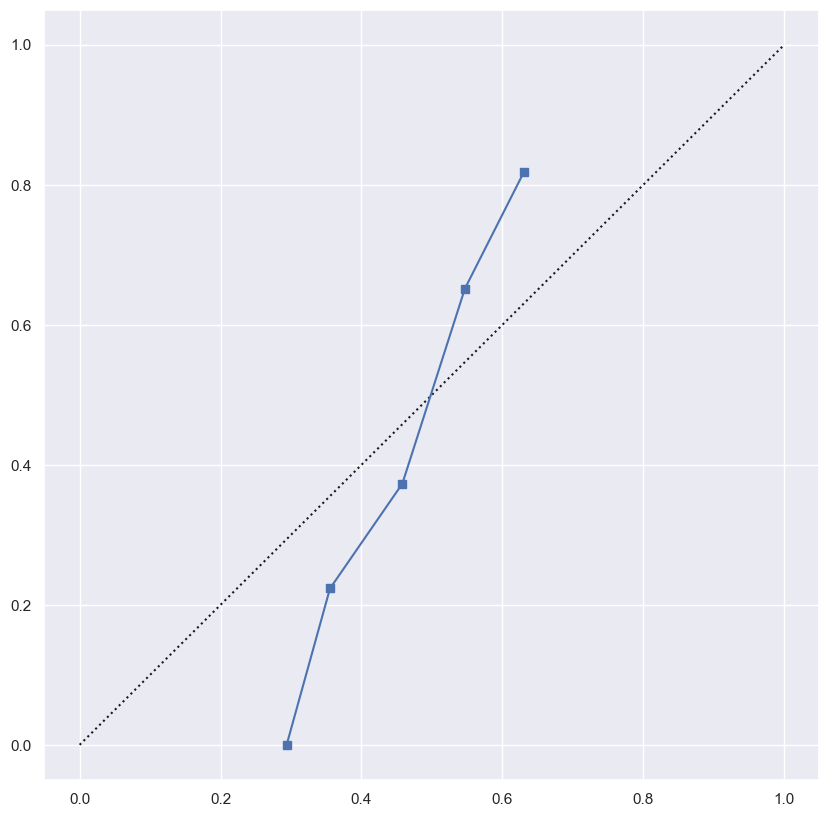

In [127]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

if hasattr(final_model, 'predict_proba'):
    prob_pos_boost = final_model.predict_proba(X_test_enc)[:, 1]
else:
    prob_pos_boost = sigmoid(final_model.predict(X_test_enc))

fraction_of_positives_boost, mean_predicted_value_boost = calibration_curve(
    y_test_bin, prob_pos_boost, n_bins=10
)

plt.plot(mean_predicted_value_boost, fraction_of_positives_boost, "s-", label="Custom Boosting")

Модель довольно неплохо оценивает вероятности.

Построим также калибровочную кривую для логистической регрессии

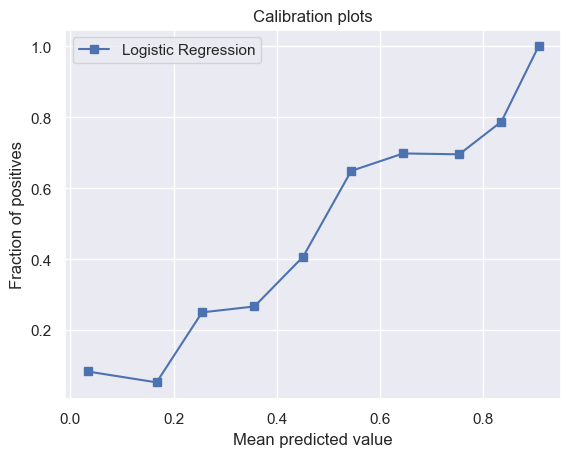

In [131]:
logreg = LogisticRegression(max_iter=1000, random_state=1337)
logreg.fit(X_train_enc, y_train_bin)
prob_pos_lr = logreg.predict_proba(X_test_enc)[:, 1]

fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(
    y_test_bin, prob_pos_lr, n_bins=10
)

plt.plot(mean_predicted_value_lr, fraction_of_positives_lr, "s-", label="Logistic Regression")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.title('Calibration plots')
plt.legend()
plt.show()

Для логистичсекой регрессии тренд более яркий, похоже на случайное блуждание с приоритетным смещением вправо. 

Конечно же, бустинг можно сделать еще лучше, если его откалибровать

Посмотреть, как изменилась мера откалиброванности, можно с помощью:\
$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$ \
$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$

# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚